# Distinguishing muffins and Chihuahuas with NNs

The aim of this project is to train a neural network for the binary classification of muffins and Chihuahuas based on the images contained in the relative [Kaggle dataset](https://www.kaggle.com/datasets/samuelcortinhas/muffin-vs-chihuahua-image-classification).

# Setup

In [1]:
import importlib
import os

def import_or_install(package_name, alias=None):
    try:
        imported_package = importlib.import_module(package_name)
        if alias:
            globals()[alias] = imported_package
        print(f"{package_name} is already installed.")
    except ImportError:
        import subprocess
        print(f"{package_name} is not installed. Installing...")
        subprocess.check_call(['pip', 'install', package_name])
        imported_package = importlib.import_module(package_name)
        if alias:
            globals()[alias] = imported_package
        print(f"{package_name} has been installed.")

FOLDERNAME = "muffin-vs-chihuahua-image-classification"
PATH = "./"

We import the dataset from Kaggle, using a token.

In [7]:
os.environ['KAGGLE_USERNAME'] = "xxx"
os.environ['KAGGLE_KEY'] = "xxx"

import_or_install("kaggle")

from kaggle.api.kaggle_api_extended import KaggleApi

api = KaggleApi()
api.authenticate()
api.dataset_download_files("samuelcortinhas/muffin-vs-chihuahua-image-classification", PATH, quiet=False)

kaggle is already installed.


100%|██████████| 474M/474M [00:18<00:00, 27.5MB/s] 

In [9]:
import zipfile
from tqdm import tqdm

with zipfile.ZipFile(PATH + FOLDERNAME + ".zip", 'r') as zip_ref:
    for file_info in tqdm(zip_ref.infolist(), desc="Extracting images from zipped folder", total=len(zip_ref.infolist())):
        zip_ref.extract(file_info, PATH + FOLDERNAME)

os.remove(PATH + FOLDERNAME +".zip")

Extracting images from zipped folder:   0%|          | 0/5917 [00:00<?, ?it/s]

Extracting images from zipped folder: 100%|██████████| 5917/5917 [00:31<00:00, 185.16it/s]


If already present we import, or otherwise we install, the `tensorflow` package. Above all functionalities we will be using the `keras` module to construct neural networks to distinguish the images in the dataset.

In [5]:
import_or_install("tensorflow","tf")
from tensorflow import keras

2024-04-22 18:06:58.628632: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-04-22 18:06:58.628662: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-04-22 18:06:58.629526: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-04-22 18:06:58.634513: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-04-22 18:06:59.159942: W tensorflow/compiler/tf2

tensorflow is already installed.


# Data pre-processing

Before proceeding we remove badly encoded images.

In [6]:
from PIL import Image
def remove_badly_encoded_images(directory):
    for filename in os.listdir(directory):
        if filename.endswith('.JPG'):
            try:
                img = Image.open(directory+filename)  # open the image file
                img.verify()  # verify that it is, in fact an image
                img.close()
            except (IOError, SyntaxError):
                os.remove(directory+filename)

deleted = remove_badly_encoded_images(PATH + FOLDERNAME + "/")
print("Deleted images:",deleted)

Deleted images: None


We begin by subdividing the dataset into training and test set. This partition is provided by the Kaggle dataset itself, with $\frac{1}{5}$ of the images assigned to the test set.

We also infer the binary labels from the layout of the dataset. Specifically the labels are assigned as follows:
\begin{equation*}
    \begin{cases}
        0  & \text{chihuahua} \\
        1  & \text{muffin}
    \end{cases}
\end{equation*}

In [7]:
def create_dataset(foldername):
    dataset_path = os.path.join(PATH, FOLDERNAME, foldername)
    return keras.utils.image_dataset_from_directory(dataset_path, labels = "inferred")

print("Training set:")
train_ds = create_dataset("train")
print("Test set")
test_ds = create_dataset("test")

Training set:
Found 4733 files belonging to 2 classes.


2024-04-22 18:06:59.979189: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-04-22 18:07:00.009654: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-04-22 18:07:00.009837: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

Test set
Found 1184 files belonging to 2 classes.


In [8]:
train_ds_path = os.path.join(PATH, FOLDERNAME, "train")

reduced_train_ds, val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    train_ds_path,
    labels='inferred',
    validation_split=0.08,
    subset="both",
    seed = 42
)

Found 4733 files belonging to 2 classes.
Using 4355 files for training.
Using 378 files for validation.


Let's give a look at a small sample of pictures with the relative annotations.

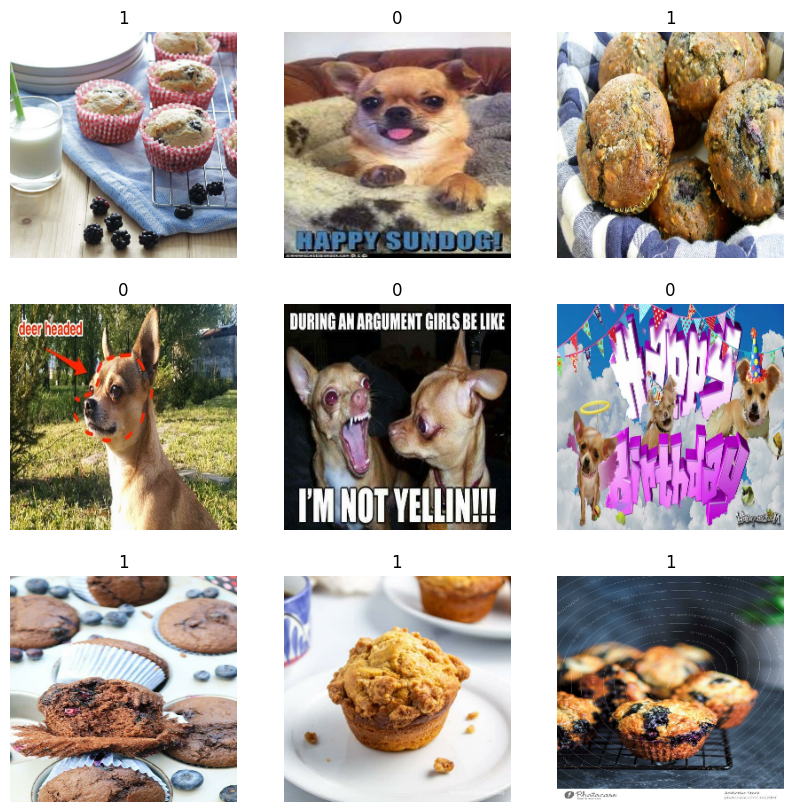

In [9]:
import matplotlib.pyplot as plt
import numpy as np

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(np.array(images[i]).astype("uint8"))
        plt.title(int(labels[i]))
        plt.axis("off")

Before diving into the actual pre-processing of the data we prepare a function that produces realistic variations of the images in the dataset. This data augmentation step is useful to make a small dataset more expressive by introducing random changes, so counteracting overfitting.

In [10]:
from keras import layers

data_augmentation_layers = [
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.2),
]

def data_augmentation(images, data_augmentation_layers, training = True):
    for layer in data_augmentation_layers:
        images = layer(images, training = training)
    return images

For example we may randomly flip the picture or slightly tilt it. We show here the potential results of the data augmentation function.

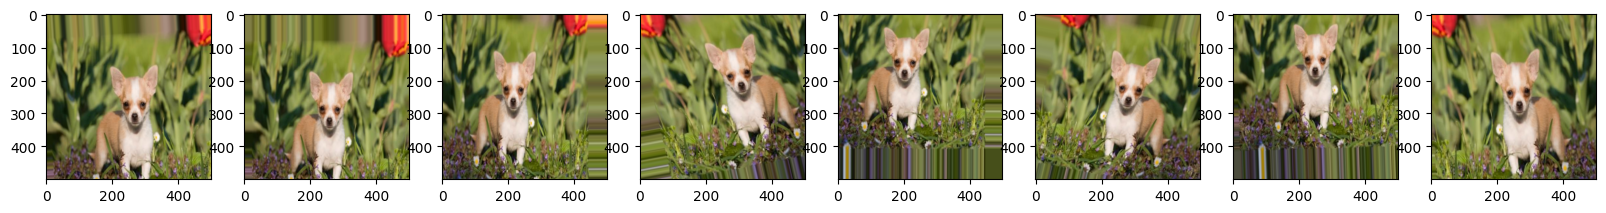

In [11]:
from keras.preprocessing.image import ImageDataGenerator
import numpy as np

random_augmentation_parameters = {
    'rotation_range': np.random.randint(-20, 20),
    'width_shift_range': np.random.uniform(0.0, 0.2),
    'height_shift_range': np.random.uniform(0.0, 0.2),
    'shear_range': np.random.uniform(0.0, 0.2),
    'zoom_range': np.random.uniform(0.0, 0.2),
    'horizontal_flip': np.random.choice([True, False])
}
pic_path = os.path.join(train_ds_path, "chihuahua", "img_0_53.jpg")
img = keras.preprocessing.image.load_img(pic_path, target_size= (500,500))
img_tensor = keras.preprocessing.image.img_to_array(img)
img_tensor = np.expand_dims(img_tensor, axis=0)

datagen = ImageDataGenerator(**random_augmentation_parameters)

pic = datagen.flow(img_tensor)
plt.figure(figsize=(20,15))

for i in range(1,9):
  plt.subplot(1, 8, i)
  batch = pic.next()
  image_ = batch[0].astype('uint8')
  plt.imshow(image_)
plt.show()


To make learning easer we simplify the images by:
* taking them in grayscale,
* reducing their dimensions by resizing them to the size $(64,64)$.

In [12]:
def rgb_to_grayscale(image):
    grayscale_image = tf.image.rgb_to_grayscale(image)
    return grayscale_image

def resize_image(image, target_size):
    resized_image = tf.image.resize(image, target_size)
    return resized_image


image_size = (64,64)

preprocess = {
    'rgb_to_grayscale': lambda x, y: (rgb_to_grayscale(x),y),
    'resize_image': lambda x,y: (resize_image(x, image_size),y)
}

for func_name, func in preprocess.items():
    train_ds = train_ds.map(func)
    test_ds = test_ds.map(func)
    reduced_train_ds = reduced_train_ds.map(func)
    val_ds = val_ds.map(func)

In [13]:
import math

def augment_dataset(dataset, data_augmentation_function, fraction):
    n_images = math.ceil(dataset.cardinality().numpy()*fraction)
    augmented_images = dataset.take(n_images).map(lambda x,y: (data_augmentation_function(x),y))
    return dataset.concatenate(augmented_images)

train_ds_augmented = augment_dataset(train_ds, lambda x: data_augmentation(x, data_augmentation_layers), 0.3)

In [14]:
(train_ds.cardinality().numpy(), train_ds_augmented.cardinality().numpy())

(148, 193)

# Model construction

To try and classify the images in the dataset we build various neural network models, and store them in the `models_configs` dictionary. For the moment we prepare the structure of each neural network, and other parameters, like `optimizer`, `loss` and `metrics`, that will be needed to build (compile) the models.

Also, instead of fixing the values that characterize the layers of the models, we have used hyperparameters placeholders. We have opted for an object of type `HyperParameter`, that allows to specify the type and domain for the desired value. These parameters will be tuned in a later step.

In the next sections we display the classes for each of the hypermodels, and the relative visual representation of the sequential layers.

In [15]:
input_shape = train_ds.element_spec[0].shape[1:]

import_or_install("pydot")
def display_hypermodel(hypermodel_class, hypermodel_name):
    hypermodel = hypermodel_class(input_shape)
    built_hypermodel = hypermodel.build(kt.HyperParameters())
    return keras.utils.plot_model(built_hypermodel, to_file=hypermodel_name +'.png', show_layer_names=True)

pydot is already installed.


In [16]:
import_or_install("keras_tuner","kt")

keras_tuner is already installed.


## Hypermodels

### Hypermodel 1

In [17]:
class HyperModel_1(kt.HyperModel):
    def __init__(self, input_shape):
        self.input_shape = input_shape

    def build(self, hp):
        model = keras.Sequential([
            layers.Input(shape=input_shape, name='input'),
            layers.Conv2D(hp.Choice('filters_1', [16, 32, 64]), np.array(hp.Choice('kernel_size_1', range(3, 6))).repeat(2), activation='relu', padding = 'valid', name='convolutional_1'),
            layers.MaxPooling2D(np.array(hp.Choice('pool_size_1', range(2, 5))).repeat(2), name='maxPooling_1'),
            layers.Conv2D(hp.Choice('filters_2', [16, 32, 64]), np.array(hp.Choice('kernel_size_2', range(3, 6))).repeat(2), activation='relu', padding = 'valid', name='convolutional_2'),
            layers.MaxPooling2D(np.array(hp.Choice('pool_size_2', range(2, 5))).repeat(2), name='maxPooling_2'),
            layers.Flatten(name='flatten'),
            layers.Dense(1, activation='sigmoid', name='output')
        ])

        model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

        return model

In [18]:
# display_hypermodel(HyperModel_1, 'hypermodel_1')

The first, simpler model, is composed by two convolutional layers, ideal for detecting patterns in images. Also, each of the convolutional layers is followed by max pooling layers, with the aim of summarizing the information extracted by passing a kernel over the images multiple times, as prescribe by the `filters` parameter.

After the first feature learning stage follows a dense layer, to connect the patterns found in the images to the desired output. Finally, the last output layer is designed to summarize this information into a unique value in the interval $\left[0,1\right]$.

### Hypermodel 2

In [19]:
class HyperModel_2(kt.HyperModel):
    def __init__(self, input_shape):
        self.input_shape = input_shape

    def build(self, hp):
        model = keras.Sequential([
            layers.Input(shape=input_shape, name='input'),
            layers.Conv2D(hp.Choice('filters_1', [16, 32, 64]), np.array(hp.Choice('kernel_size_1', range(3, 6))).repeat(2), activation='relu', padding = 'valid', name='convolutional_1'),
            layers.MaxPooling2D(np.array(hp.Choice('pool_size_1', range(2, 5))).repeat(2), name='maxPooling_1'),
            layers.Conv2D(hp.Choice('filters_2', [16, 32, 64]), np.array(hp.Choice('kernel_size_2', range(3, 6))).repeat(2), activation='relu', padding = 'valid', name='convolutional_2'),
            layers.MaxPooling2D(np.array(hp.Choice('pool_size_2', range(2, 5))).repeat(2), name='maxPooling_2'),
            layers.Flatten(name='flatten'),
            layers.Dense(hp.Choice('units',[32,64,96]), activation='relu', name = 'dense_1'),
            layers.Dense(1, activation='sigmoid', name='output')
        ])

        model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

        return model

In [20]:
# display_hypermodel(HyperModel_2,'hypermodel_2')

### Hypermodel 3

In [21]:
class HyperModel_3(kt.HyperModel):
    def __init__(self, input_shape):
        self.input_shape = input_shape

    def build(self, hp):
        model = keras.Sequential([
            layers.Input(shape=self.input_shape, name='input'),
            layers.Conv2D(hp.Choice('filters_1', [16, 32, 64]), np.array(hp.Choice('kernel_size_1', range(3, 6))).repeat(2), activation='relu', padding = 'same', name='convolutional_1'),
            layers.MaxPooling2D(np.array(hp.Choice('pool_size_1', range(2, 5))).repeat(2), name='maxPooling_1'),
            layers.Conv2D(hp.Choice('filters_2', [16, 32, 64]), np.array(hp.Choice('kernel_size_2', range(3, 6))).repeat(2), activation='relu', padding = 'same', name='convolutional_2'),
            layers.MaxPooling2D(np.array(hp.Choice('pool_size_2', range(2, 5))).repeat(2), name='maxPooling_2'),
            layers.Conv2D(hp.Choice('filters_3', [16, 32, 64]), np.array(hp.Choice('kernel_size_3', range(3, 6))).repeat(2), activation='relu', padding = 'same', name='convolutional_3'),
            layers.MaxPooling2D(np.array(hp.Choice('pool_size_3', range(2, 5))).repeat(2), name='maxPooling_3'),
            layers.Flatten(name='flatten'),
            layers.Dense(1, activation='sigmoid', name='output')
        ])

        model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

        return model

In [22]:
# display_hypermodel(HyperModel_3, 'hypermodel_3')

For this model we wanted to study the quality of the prediction obtained by adding an additional pair of convolutional and max pooling layers.

### Hypermodel 4

In [23]:
class HyperModel_4(kt.HyperModel):
    def __init__(self, input_shape):
        self.input_shape = input_shape

    def build(self, hp):
        model = keras.Sequential([
            layers.Input(shape=self.input_shape, name='input'),
            layers.Conv2D(hp.Choice('filters_1', [16, 32, 64]), np.array(hp.Choice('kernel_size_1', range(3, 6))).repeat(2), activation='relu', padding = 'same', name='convolutional_1'),
            layers.MaxPooling2D(np.array(hp.Choice('pool_size_1', range(2, 5))).repeat(2), name='maxPooling_1'),
            layers.Conv2D(hp.Choice('filters_2', [16, 32, 64]), np.array(hp.Choice('kernel_size_2', range(3, 6))).repeat(2), activation='relu', padding = 'same', name='convolutional_2'),
            layers.MaxPooling2D(np.array(hp.Choice('pool_size_2', range(2, 5))).repeat(2), name='maxPooling_2'),
            layers.Conv2D(hp.Choice('filters_3', [16, 32, 64]), np.array(hp.Choice('kernel_size_3', range(3, 6))).repeat(2), activation='relu', padding = 'same', name='convolutional_3'),
            layers.MaxPooling2D(np.array(hp.Choice('pool_size_3', range(2, 5))).repeat(2), name='maxPooling_3'),
            layers.Flatten(name='flatten'),
            layers.Dense(hp.Choice('units',[32,64,96]), activation='relu', name = 'dense_1'),
            layers.Dense(1, activation='sigmoid', name='output')
        ])

        model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

        return model

In [24]:
# display_hypermodel(HyperModel_4, 'hypermodel_4')

Lastly, we were curious to see the effect of inserting a flattening layer between extracting image features and relating such patterns to the classification problem. By flattening the results of the convolutional networks we are reducing the expressivity of the foundings, but we are also simplifying the task left for the two last layers.

## Hyperparameter tuning

Now that we have outlined the structure of the neural networks we choose the hyperparameters for each layer. Specifically we are looking to valorize the following parameters:
* convolutional layers (type `Conv2D`)
    * number of filters
    * size of the kernels, square in shape
* max pooling layers (type `MaxPooling2D`)
    * size of the pool
* dense layers that are no output layers (type `Dense`)
    * number of
    
To do this we use the `keras_tune` library {cite}`omalley2019kerastuner`, that allows hyperparameter tuning. It allows to build a `Tuner` object based on a compiled Keras model that has as argument a `Hyperparameter` object. Such a tuner can then search for the best possible hyperparameters for the model and value domains that have been supplied. For efficiency reasons we have opted for a random search in the hyperparameter space, in fact we have set the `max_trials` option such that only a portion of the combinations of hyperparameters will be evaluated.   
The tuner also acts as a log for the hyperparameter combinations that have ben tested, that will become useful in the experiment section.

If present, the prepared tuners are loaded from the *tuners* directory.

In [25]:
hypermodels = {
    'hypermodel_1': HyperModel_1,
    'hypermodel_2': HyperModel_2,
    'hypermodel_3': HyperModel_3,
    'hypermodel_4': HyperModel_4
}

In [26]:
def tune_hypermodel(model_name, model_class, train_ds, test_ds, directory, max_trials):
    tuner = kt.RandomSearch(
        model_class(input_shape),
        objective = 'val_accuracy',
        directory = directory,
        max_trials = max_trials,
        project_name = model_name)

    tuner.search(train_ds, epochs = 10, validation_data = test_ds)

    return tuner

In [27]:
tf.config.list_physical_devices("GPU")

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [28]:
tuners = {}
for hypermodel_name, hypermodel_class in hypermodels.items():
    with tf.device('/device:GPU:0'):
        tuners[hypermodel_name] = tune_hypermodel(hypermodel_name, hypermodel_class, train_ds, test_ds, '/mnt/data/NNChihuahuaMuffin/tuners', 10)

Reloading Tuner from /mnt/data/NNChihuahuaMuffin/tuners/hypermodel_1/tuner0.json
Reloading Tuner from /mnt/data/NNChihuahuaMuffin/tuners/hypermodel_2/tuner0.json
Reloading Tuner from /mnt/data/NNChihuahuaMuffin/tuners/hypermodel_3/tuner0.json
Reloading Tuner from /mnt/data/NNChihuahuaMuffin/tuners/hypermodel_4/tuner0.json


Let's give a look at the best hyperparameter values that the tuners have found for the hypermodels with respect to the loss that the model produces.

In [29]:
import_or_install("pandas","pd")

def tuners_get_best_hyperparameters(tuners, hypermodels):
    best_hps = {}
    for hypermodel_name in hypermodels:
        best_hps[hypermodel_name] = tuners[hypermodel_name].get_best_hyperparameters()[0]
    return best_hps   
        
def tuners_display_best_hyperparameters(tuners, hypermodels):
    best_hps = tuners_get_best_hyperparameters(tuners, hypermodels)
    best_hps_values = {k: v.values for k, v in best_hps.items()}
    print(pd.DataFrame.from_dict(best_hps_values).fillna("-"))

pandas is already installed.


In [30]:
tuners_display_best_hyperparameters(tuners, hypermodels)

              hypermodel_1 hypermodel_2 hypermodel_3  hypermodel_4
filters_1             64.0         32.0         32.0            64
kernel_size_1          3.0          3.0          5.0             4
pool_size_1            4.0          3.0          2.0             3
filters_2             64.0         64.0         32.0            64
kernel_size_2          3.0          4.0          3.0             3
pool_size_2            4.0          3.0          4.0             3
units                    -         32.0            -            32
filters_3                -            -         32.0            64
kernel_size_3            -            -          5.0             4
pool_size_3              -            -          3.0             3


And here are the losses with respect to binary cross entropy that have been computed respectively for each of the models with the best hyperparameters.

In [31]:
def tuners_display_metrics(tuners, hypermodels):
    best_metrics = {}
    for hypermodel_name in hypermodels:
        best_metrics[hypermodel_name] = tuners[hypermodel_name].oracle.get_best_trials(1)[0].score
    print(pd.DataFrame({ k:[v] for (k,v) in best_metrics.items()}, index = ["loss"]))

In [32]:
tuners_display_metrics(tuners, hypermodels)

      hypermodel_1  hypermodel_2  hypermodel_3  hypermodel_4
loss      0.842061      0.856419      0.858108      0.864865


We now repeat this procedure for the augmented training set. By adding images obtained by randomly modifying the ones already present in the dataset we should avoid overfitting. So we suppose that for the models obtained through these hyperparameters the risk will be less.

In [33]:
tuners_augmented = {}
for hypermodel_name, hypermodel_class in hypermodels.items():
    with tf.device('/GPU:0'):
        tuners_augmented[hypermodel_name] = tune_hypermodel(hypermodel_name, hypermodel_class, train_ds_augmented, test_ds, '/mnt/data/NNChihuahuaMuffin/tuners_augmented', 100)

Reloading Tuner from /mnt/data/NNChihuahuaMuffin/tuners_augmented/hypermodel_1/tuner0.json
Reloading Tuner from /mnt/data/NNChihuahuaMuffin/tuners_augmented/hypermodel_2/tuner0.json
Reloading Tuner from /mnt/data/NNChihuahuaMuffin/tuners_augmented/hypermodel_3/tuner0.json
Reloading Tuner from /mnt/data/NNChihuahuaMuffin/tuners_augmented/hypermodel_4/tuner0.json


In [34]:
tuners_display_best_hyperparameters(tuners_augmented, hypermodels)

              hypermodel_1 hypermodel_2 hypermodel_3  hypermodel_4
filters_1             64.0         16.0         64.0            64
kernel_size_1          4.0          4.0          4.0             4
pool_size_1            2.0          2.0          4.0             3
filters_2             64.0         64.0         64.0            64
kernel_size_2          3.0          4.0          4.0             5
pool_size_2            3.0          4.0          3.0             4
units                    -         32.0            -            64
filters_3                -            -         16.0            64
kernel_size_3            -            -          5.0             4
pool_size_3              -            -          4.0             4


In [35]:
tuners_display_metrics(tuners_augmented, hypermodels)

      hypermodel_1  hypermodel_2  hypermodel_3  hypermodel_4
loss      0.827703      0.847973      0.845439      0.859797


In [36]:
tuners_validation = {}
for hypermodel_name, hypermodel_class in hypermodels.items():
    with tf.device('/GPU:0'):
        tuners_validation[hypermodel_name] = tune_hypermodel(hypermodel_name, hypermodel_class, reduced_train_ds, val_ds, '/mnt/data/NNChihuahuaMuffin/tuners_validation', 300)

Reloading Tuner from /mnt/data/NNChihuahuaMuffin/tuners_validation/hypermodel_1/tuner0.json
Reloading Tuner from /mnt/data/NNChihuahuaMuffin/tuners_validation/hypermodel_2/tuner0.json
Reloading Tuner from /mnt/data/NNChihuahuaMuffin/tuners_validation/hypermodel_3/tuner0.json
Reloading Tuner from /mnt/data/NNChihuahuaMuffin/tuners_validation/hypermodel_4/tuner0.json


In [39]:
def dataset_to_numpy_arrays(dataset):   
    dataset.unbatch()  
    X = []
    y = []
    for features, labels in dataset:
        X.append(features.numpy())
        y.append(labels.numpy())
    X = np.array(X)
    y = np.array(y)
    return X,y

train_generator = datagen.flow(dataset_to_numpy_arrays(reduced_train_ds))
tuners_validation_augmented = {}
for hypermodel_name, hypermodel_class in hypermodels.items():
    with tf.device('/GPU:0'):
        tuners_validation_augmented[hypermodel_name] = tune_hypermodel(hypermodel_name, hypermodel_class, train_generator, val_ds, '/mnt/data/NNChihuahuaMuffin/tuners_validation_augmented', 300)
    

Reloading Tuner from /mnt/data/NNChihuahuaMuffin/tuners_validation_augmented/hypermodel_1/tuner0.json
Reloading Tuner from /mnt/data/NNChihuahuaMuffin/tuners_validation_augmented/hypermodel_2/tuner0.json
Reloading Tuner from /mnt/data/NNChihuahuaMuffin/tuners_validation_augmented/hypermodel_3/tuner0.json
Reloading Tuner from /mnt/data/NNChihuahuaMuffin/tuners_validation_augmented/hypermodel_4/tuner0.json


Now that we have found a collection of good hyperparameters, we build the resulting models, that will serve as a starting point for the evaluation of the quality of the models. We do this for the hyperparameters extracted by using the original training set and the augmented version.

In [ ]:
def get_best_models(tuners, hypermodels):
    best_model = {}
    best_hps = tuners_get_best_hyperparameters(tuners, hypermodels)
    for hypermodel_name, hypermodel_class in hypermodels.items():
        hps = best_hps[hypermodel_name]
        model = hypermodel_class(input_shape)
        best_model[hypermodel_name[5:]] = model.build(hps)
    return best_model

In [ ]:
best_models = get_best_models(tuners, hypermodels)
best_models_augmented = get_best_models(tuners_augmented, hypermodels)
best_models_validation = get_best_models(tuners_validation, hypermodels)
best_models_validation_augmented = get_best_models(tuners_validation_augmented, hypermodels)    

NameError: name 'get_best_models' is not defined

# Evaluation

We will evaluate the various neural networks according to their risk with zero-one loss. We will estimate such measure using $5$-fold cross validation.

We initially convert the dataset, formed by concatenating the training and test set used before, into a numpy array. This new structure converts the dataset into a fixed sequence, so it makes it possible to determine sets of indices to split the datasets into folds.

In [ ]:
dataset = train_ds.concatenate(test_ds)
X,y = dataset_to_numpy_arrays(dataset)

Here we prepare the functions that we will use to perform the cross validation. We have chosen to round the predicted labels in $\left[0,1\right]$.

In [ ]:
from sklearn.metrics import zero_one_loss
from sklearn.model_selection import KFold
from keras.callbacks import EarlyStopping


def fold_validation(model, X, y, train_index, test_index):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    
    # Fit model on training portion of the fold
    print("\nFitting model to train portion")
    callback = EarlyStopping(monitor='val_loss', patience=3)
    model.fit(X_train, y_train, epochs = 100, batch_size = 16, callbacks = [callback])
    
    #Predict labels for the test portion of the fold
    print("\nPredicting labels for test portion")
    predicted_labels_continuous = model.predict(X_test)
    predicted_labels = [round(l[0]) for l in predicted_labels_continuous]
    loss = zero_one_loss(y_test, predicted_labels)
    return loss

def cross_validation(model, model_name, X, y, num_folds):
    kf = KFold(n_splits=num_folds)
    
    losses = [0]*num_folds
    for i,(train_index, test_index) in enumerate(kf.split(X)):
        print(f"Fold: {i+1}")
        model.load_weights(f"/mnt/data/NNChihuahuaMuffin/{model_name}.h5")
        losses[i] = fold_validation(model, X, y, train_index, test_index)
        
    return losses
      

We also log the risks estimated by the cross validation process to archive computations executed beforehand. At this scope we define a class `LossesJson` that allows to maintain and modify a json array also saved in a dedicated file in the present directory with name *filename*.

In [ ]:
import json

class LossesJson:
    def __init__(self, filename):
        self.filename = filename
        self.losses = {}
        
    def __str__(self):        
        aesthetic_dict = {
            model: {
                    **model_data["loss_folds"],
                    "loss_cv": model_data["loss_cv"]
                }
            for model, model_data in self.losses.items()
        }
        return str(pd.DataFrame.from_dict(aesthetic_dict))
    

    def update(self, model_name, losses):
        def losses_to_dict(loss_cv, loss_folds):
            losses_dict = {}
            num_folds = len(loss_folds)
            losses_dict["loss_folds"] = {}
            for fold in range(num_folds):
                fold_name =  f"fold_{fold+1}"
                losses_dict["loss_folds"][fold_name] = loss_folds[fold]
            losses_dict["loss_cv"] = loss_cv
            return losses_dict
        
        self.losses[model_name] = losses_to_dict(np.mean(losses), losses)
        self.save()

    def save(self):
        with open(self.filename, 'w') as file:
            json.dump(self.losses, file, indent = 4)

    def load(self):
        with open(self.filename, 'r') as file:
            self.losses = json.load(file)
            
    def get_losses(self):
        self.load()
        return self.losses


We prepare a utility function that we will use to execute cross validation and save its progress. If a *filename.json* is already located in the present directory, it's content will be loaded to access the possible precomputed losses for some of the models (with respect to the provided dataset).

In [ ]:
from os.path import exists
from multiprocessing import Pool

def save_execute_cross_validation_on_models(filename, models, X,y, num_folds):
    
    # Setup filename.json contents
    with open(filename, 'w') as file:
        json.dump({}, file, indent = 4)
    # Initialize LossesJson object
    losses_json = LossesJson(filename)
    
    # Load losses from filename.json
    if exists(filename):
        losses_json.load()
        print(f"Loading losses from {filename} for models: ")
    
    # Get models for which there are no precomputed losses
    models_without_losses = dict(models)
    for key in losses_json.get_losses():
        print(f"{key} ")
        models_without_losses.pop(key)
    
    # Execute cross validation on models without precomputed losses
    if len(models_without_losses):        
        for model_name, model_class in models_without_losses.items():
            print(f"### Cross_validation for model: {model_name} ###")
            model_class.save_weights(f"/mnt/data/NNChihuahuaMuffin/{model_name}.h5")
            losses = cross_validation(model_class, model_name, X,y, num_folds)
            print(f"### Cross_validation results for model: {model_name} ###")
            print(f"Losses: {losses}")
            print(f"Cross validation loss: {np.mean(losses)}")
            losses_json.update(model_name, losses)
    
    return losses_json

We first of all look at the risk approximation for the best model we have found for each of the hypermodels by training on the original Kaggle dataset. These values are a reference to discuss the best performing hypermodel, and to try and motivate why the tuner had settled for the chosen hyperparameters.

In [ ]:
with tf.device('/GPU:0'):
    losses_json_best_models = save_execute_cross_validation_on_models("/mnt/data/NNChihuahuaMuffin/losses.json", best_models, X, y, 5)


Cross_validation for model: model_1
Fold: 1
Fitting model to train portion
Epoch 1/100


2024-04-20 11:29:26.397382: W external/local_tsl/tsl/framework/bfc_allocator.cc:296] Allocator (GPU_0_bfc) ran out of memory trying to allocate 31.02MiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2024-04-20 11:29:26.397404: W tensorflow/core/kernels/gpu_utils.cc:54] Failed to allocate memory for convolution redzone checking; skipping this check. This is benign and only means that we won't check cudnn for out-of-bounds reads and writes. This message will only be printed once.
2024-04-20 11:29:26.415174: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8907
2024-04-20 11:29:26.465841: W external/local_tsl/tsl/framework/bfc_allocator.cc:296] Allocator (GPU_0_bfc) ran out of memory trying to allocate 16.02MiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if mor

NotFoundError: Graph execution error:

Detected at node sequential/convolutional_1/Relu defined at (most recent call last):
  File "/usr/lib/python3.10/runpy.py", line 196, in _run_module_as_main

  File "/usr/lib/python3.10/runpy.py", line 86, in _run_code

  File "/home/coso/.local/lib/python3.10/site-packages/ipykernel_launcher.py", line 18, in <module>

  File "/home/coso/.local/lib/python3.10/site-packages/traitlets/config/application.py", line 1075, in launch_instance

  File "/home/coso/.local/lib/python3.10/site-packages/ipykernel/kernelapp.py", line 739, in start

  File "/home/coso/.local/lib/python3.10/site-packages/tornado/platform/asyncio.py", line 205, in start

  File "/usr/lib/python3.10/asyncio/base_events.py", line 603, in run_forever

  File "/usr/lib/python3.10/asyncio/base_events.py", line 1909, in _run_once

  File "/usr/lib/python3.10/asyncio/events.py", line 80, in _run

  File "/home/coso/.local/lib/python3.10/site-packages/ipykernel/kernelbase.py", line 545, in dispatch_queue

  File "/home/coso/.local/lib/python3.10/site-packages/ipykernel/kernelbase.py", line 534, in process_one

  File "/home/coso/.local/lib/python3.10/site-packages/ipykernel/kernelbase.py", line 437, in dispatch_shell

  File "/home/coso/.local/lib/python3.10/site-packages/ipykernel/ipkernel.py", line 362, in execute_request

  File "/home/coso/.local/lib/python3.10/site-packages/ipykernel/kernelbase.py", line 778, in execute_request

  File "/home/coso/.local/lib/python3.10/site-packages/ipykernel/ipkernel.py", line 449, in do_execute

  File "/home/coso/.local/lib/python3.10/site-packages/ipykernel/zmqshell.py", line 549, in run_cell

  File "/home/coso/.local/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3075, in run_cell

  File "/home/coso/.local/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3130, in _run_cell

  File "/home/coso/.local/lib/python3.10/site-packages/IPython/core/async_helpers.py", line 129, in _pseudo_sync_runner

  File "/home/coso/.local/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3334, in run_cell_async

  File "/home/coso/.local/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3517, in run_ast_nodes

  File "/home/coso/.local/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3577, in run_code

  File "/tmp/ipykernel_122796/2388502517.py", line 2, in <module>

  File "/tmp/ipykernel_122796/4045864826.py", line 26, in save_execute_cross_validation_on_models

  File "/tmp/ipykernel_122796/318857368.py", line 29, in cross_validation

  File "/tmp/ipykernel_122796/318857368.py", line 13, in fold_validation

  File "/home/coso/.local/lib/python3.10/site-packages/keras/src/utils/traceback_utils.py", line 65, in error_handler

  File "/home/coso/.local/lib/python3.10/site-packages/keras/src/engine/training.py", line 1807, in fit

  File "/home/coso/.local/lib/python3.10/site-packages/keras/src/engine/training.py", line 1401, in train_function

  File "/home/coso/.local/lib/python3.10/site-packages/keras/src/engine/training.py", line 1384, in step_function

  File "/home/coso/.local/lib/python3.10/site-packages/keras/src/engine/training.py", line 1373, in run_step

  File "/home/coso/.local/lib/python3.10/site-packages/keras/src/engine/training.py", line 1150, in train_step

  File "/home/coso/.local/lib/python3.10/site-packages/keras/src/utils/traceback_utils.py", line 65, in error_handler

  File "/home/coso/.local/lib/python3.10/site-packages/keras/src/engine/training.py", line 590, in __call__

  File "/home/coso/.local/lib/python3.10/site-packages/keras/src/utils/traceback_utils.py", line 65, in error_handler

  File "/home/coso/.local/lib/python3.10/site-packages/keras/src/engine/base_layer.py", line 1149, in __call__

  File "/home/coso/.local/lib/python3.10/site-packages/keras/src/utils/traceback_utils.py", line 96, in error_handler

  File "/home/coso/.local/lib/python3.10/site-packages/keras/src/engine/sequential.py", line 398, in call

  File "/home/coso/.local/lib/python3.10/site-packages/keras/src/engine/functional.py", line 515, in call

  File "/home/coso/.local/lib/python3.10/site-packages/keras/src/engine/functional.py", line 672, in _run_internal_graph

  File "/home/coso/.local/lib/python3.10/site-packages/keras/src/utils/traceback_utils.py", line 65, in error_handler

  File "/home/coso/.local/lib/python3.10/site-packages/keras/src/engine/base_layer.py", line 1149, in __call__

  File "/home/coso/.local/lib/python3.10/site-packages/keras/src/utils/traceback_utils.py", line 96, in error_handler

  File "/home/coso/.local/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py", line 321, in call

  File "/home/coso/.local/lib/python3.10/site-packages/keras/src/activations.py", line 306, in relu

  File "/home/coso/.local/lib/python3.10/site-packages/keras/src/backend.py", line 5395, in relu

No algorithm worked!  Error messages:
  Profiling failure on CUDNN engine eng11{}: RESOURCE_EXHAUSTED: Out of memory while trying to allocate 16777216 bytes.
  Profiling failure on CUDNN engine eng0{}: RESOURCE_EXHAUSTED: Out of memory while trying to allocate 16777216 bytes.
	 [[{{node sequential/convolutional_1/Relu}}]] [Op:__inference_train_function_16667]

In [ ]:
print(losses_json_best_models)

          model_1   model_2   model_3   model_4
fold_1   0.177365  0.178209  0.147804  0.161318
fold_2   0.171453  0.160473  0.205236  0.198480
fold_3   0.160609  0.490279  0.194421  0.251057
fold_4   0.147084  0.179205  0.196957  0.167371
fold_5   0.174134  0.165680  0.194421  0.219780
loss_cv  0.166129  0.234769  0.187768  0.199601


We also look at the results for the models obtained by choosing the hyperparameters that allow the augmented training set to fit best.

In [ ]:
with tf.device('/GPU:0'):
    losses_json_best_models_augmented = save_execute_cross_validation_on_models("/mnt/data/NNChihuahuaMuffin/losses_augmented.json",  best_models_augmented, X, y, 5)


NameError: name 'tf' is not defined

In [ ]:
print(losses_json_best_models_augmented)

          model_1   model_2   model_3   model_4
fold_1   0.214527  0.174831  0.163851  0.174831
fold_2   0.197635  0.455236  0.179054  0.169764
fold_3   0.183432  0.185968  0.176669  0.168216
fold_4   0.203719  0.165680  0.157227  0.147084
fold_5   0.195266  0.173288  0.459003  0.187658
loss_cv  0.198916  0.231001  0.227161  0.169511


In [ ]:
with tf.device('/GPU:0'):
    losses_json_best_models_validation = save_execute_cross_validation_on_models("/mnt/data/NNChihuahuaMuffin/losses_validation.json",  best_models_validation, X, y, 5)


NameError: name 'tf' is not defined

In [ ]:
print(losses_json_best_models_validation)

          model_1   model_2   model_3   model_4
fold_1   0.214527  0.174831  0.163851  0.174831
fold_2   0.197635  0.455236  0.179054  0.169764
fold_3   0.183432  0.185968  0.176669  0.168216
fold_4   0.203719  0.165680  0.157227  0.147084
fold_5   0.195266  0.173288  0.459003  0.187658
loss_cv  0.198916  0.231001  0.227161  0.169511


In [ ]:
with tf.device('/GPU:0'):
    losses_json_best_models_validation_augmented = save_execute_cross_validation_on_models("/mnt/data/NNChihuahuaMuffin/losses_validation_augmented.json",  best_models_augmented, X, y, 5)


NameError: name 'tf' is not defined

In [ ]:
print(losses_json_best_models_validation_augmented)

          model_1   model_2   model_3   model_4
fold_1   0.214527  0.174831  0.163851  0.174831
fold_2   0.197635  0.455236  0.179054  0.169764
fold_3   0.183432  0.185968  0.176669  0.168216
fold_4   0.203719  0.165680  0.157227  0.147084
fold_5   0.195266  0.173288  0.459003  0.187658
loss_cv  0.198916  0.231001  0.227161  0.169511
